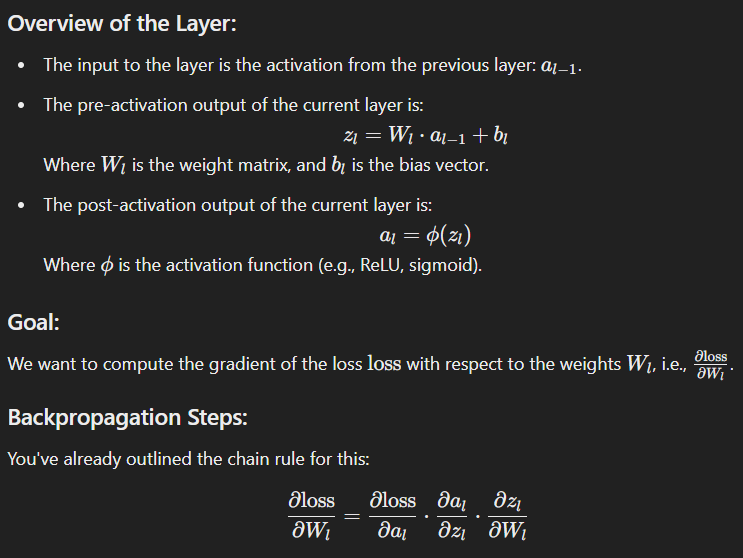

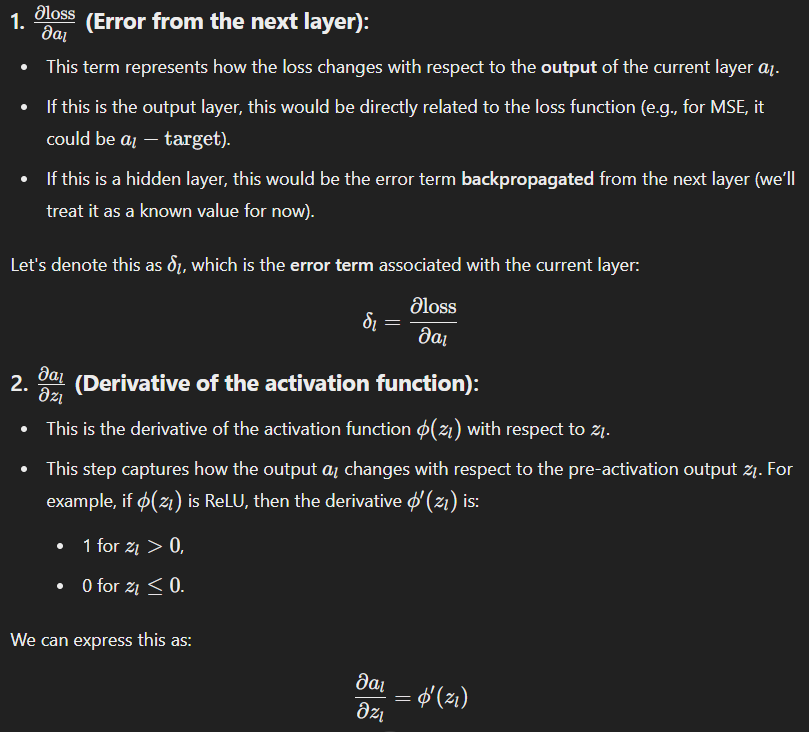

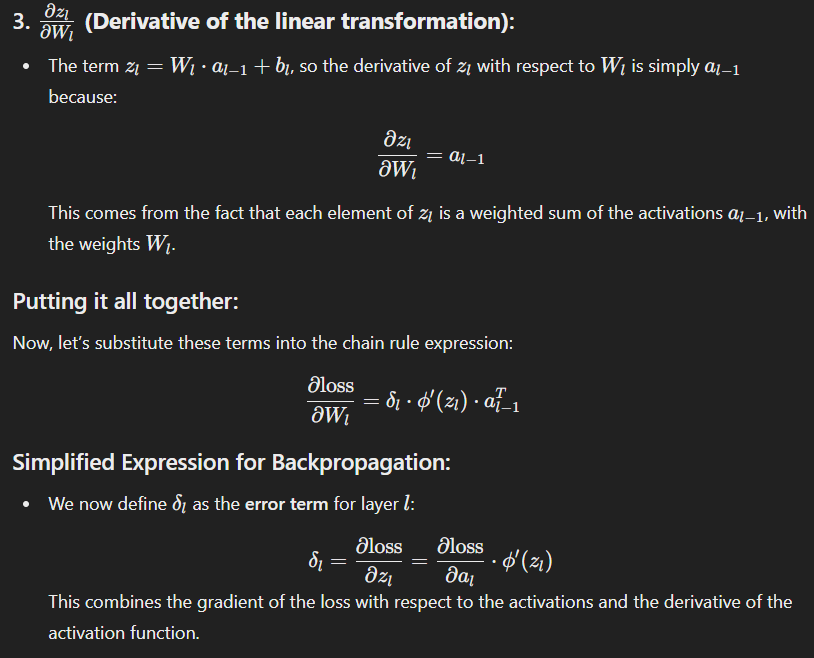

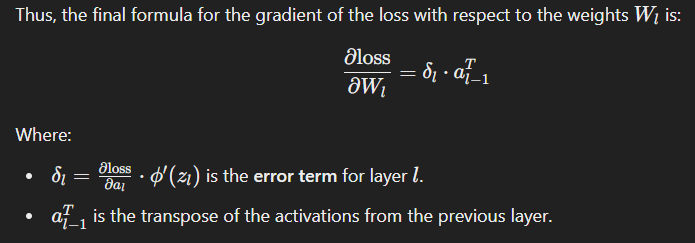

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [4]:
# download the names.txt file from github
# !wget https://raw.githubusercontent.com/Paradox3333/Transformers-from-scratch/main/names.txt

In [5]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Backprop

In [8]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s: str, dt: float, t: torch.tensor) -> None:
  ex = torch.all(dt == t.grad).item() # This function checks whether all elements in a tensor satisfy a given condition. Returns a tensor of size 1 with True/False.
  app = torch.allclose(dt, t.grad)    # This function checks if two tensors are approximately equal element-wise.
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [9]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [10]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [11]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True) # Sum of exponentials for each eow (denominator for Softmax).
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv # Softmax
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss


tensor(3.3450, grad_fn=<NegBackward0>)

## Exercise 1:

In [12]:
# Explanations (important for grad calculations):
# https://www.youtube.com/watch?v=q8SA3rM6ckI&t=426s

In [13]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

# 1 grad per element needed -> ensure correct dimensions. Remember that matrix multiplications here are ELEMENT-WISE!

# Backprop chain:
# TIP: Imagine nodes forming a computational graph.

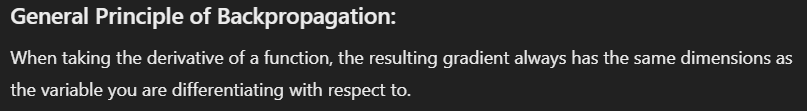

In [14]:
# ∂Loss/∂logprobs
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n

# ∂Loss/∂probs = ∂logprobs/∂probs * ∂Loss/∂logprobs
dprobs = (1.0/probs) * dlogprobs    # (32, 27) * (32, 27) = (32, 27), same as "probs".

# ∂Loss/∂counts_sum_inv = ∂probs/∂counts_sum_inv * ∂Loss/∂probs    
# But remember that Pytorch is also doing broadcasting. So here we actually have 2 operations in "probs = counts * counts_sum_inv", which is (32, 27) * (32, 1) = (32, 27)
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)  # Row sum   ,       # Remember that gradients have to sum when nodes branch.
# (32, 27) * (32, 27) then sum = (32, 1), same as "counts_sum_inv".

# Ex:

# c = a * b, but with tensors (same as probs = counts * counts_sum_inv):
# a[3x3] * b[3,1] = c[3x3] (element-wise)
# =
# a11*b1  a12*b1  a13*b1            # the b elements are contributing to each row, and that is why the sum is row-wise, because we need to sum the 
# a21*b2  a22*b2  a23*b2            # contributions of each part.
# a31*b3  a32*b3  a33*b3

# ∂Loss/∂counts_sum = ∂counts_sum_inv/∂counts_sum * ∂Loss/∂counts_sum_inv
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv   # (32, 1) * (32, 1) = (32, 1)        , same shape as "counts_sum".

In [15]:
# "counts" is a node that is used twice, once to calc "probs" and once to calc "counts_sum_inv".
# ∂Loss/∂counts = (∂probs/∂counts * ∂Loss/∂probs) + (∂counts_sum/∂counts * ∂counts_sum_inv/∂counts_sum * ∂Loss/∂counts_sum_inv)

# First contribution of "dcounts": (∂probs/∂counts * ∂Loss/∂probs)
dcounts = counts_sum_inv * dprobs   # (32, 1) * (32, 27) w/ broadcasting = (32, 27), same shape as "counts".
# Second contribution: (∂counts_sum/∂counts * ∂counts_sum_inv/∂counts_sum * ∂Loss/∂counts_sum_inv) = (∂counts_sum/∂counts * ∂Loss/∂counts_sum)
dcounts += torch.ones_like(counts) * dcounts_sum    # add contributions

# Ex: 
# counts_sum               =  counts.sum(1, keepdims=True)
#  (32, 1)                 , (32, 27)
# b1 (= a11 + a12 + a13) <--- a11 a12 a13
# b2 (= a21 + a22 + a23) <--- a21 a22 a23
# b3 (= a31 + a32 + a33) <--- a31 a32 a33

#### Second contribution:

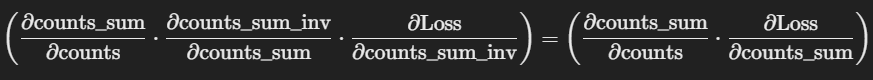

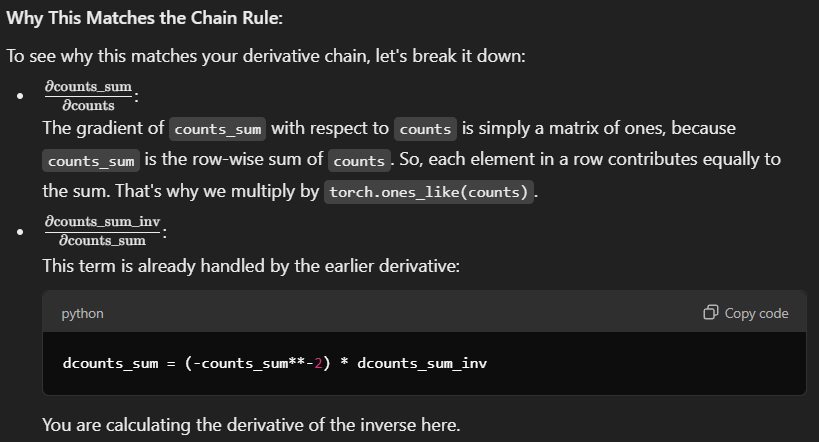

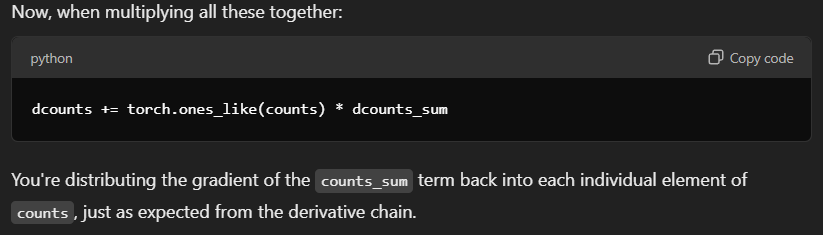

In [16]:
# ∂Loss/∂norm_logits = ∂counts/∂norm_logits * ∂Loss/∂counts
# which is: dnorm_logits = norm_logits.exp() * dcounts
dnorm_logits = counts * dcounts # better since "counts = norm_logits.exp()"

In [17]:
# ∂Loss/∂logit_maxes = ∂norm_logits/∂logit_maxes * ∂Loss/∂norm_logits
dlogit_maxes = (-1 * dnorm_logits).sum(1, keepdim=True)

# .sum needed again because of broadcasting:

# Ex:

# c11 c12 c13 = a11 a12 a13       b1                            c11 c12 c13 = a11 a12 a13       b1 b1 b1
# c21 c22 c23 = a21 a22 a23   -   b2            --->            c21 c22 c23 = a21 a22 a23   -   b2 b2 b2
# c31 c32 c33 = a31 a32 a33       b3                            c31 c32 c33 = a31 a32 a33       b3 b3 b3

# so e.g. c32 = a32 - b3


# Note: Recall that the subtraction of "logit_maxes" from "logits" is done for numerical stability so the .exp() does not overflow and that as long as
#       the subtracted value is the same for all elements in 1 row of logits (the probability distribution), "probs" does not change. We therefore expect
#       "dlogit_maxes" to be 0 (it is actually very close to 0 due to floating point inaccuracies, but same thing).


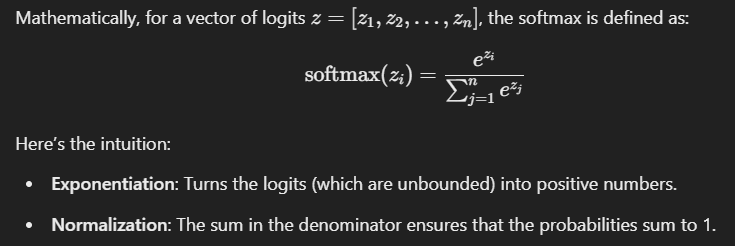

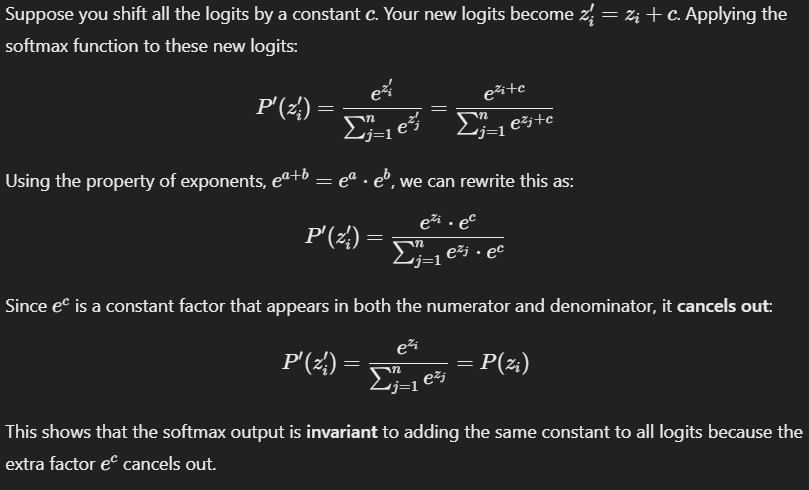

In [18]:
# --------------------------------------------------------------------------------------------------------

#### Connection between logits and probability distributions:

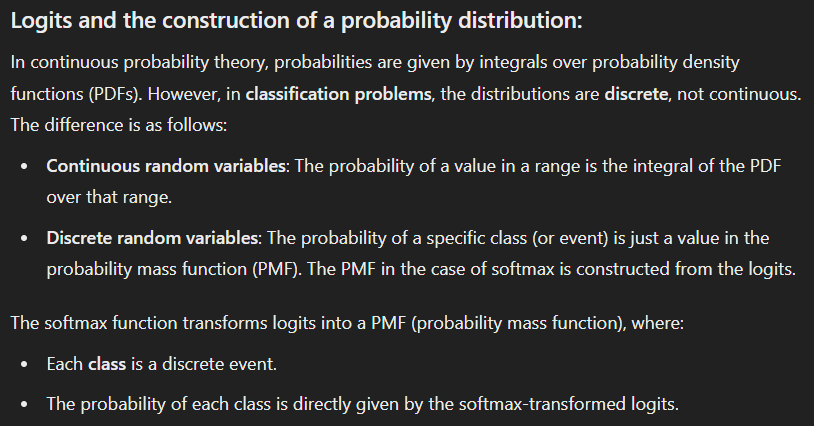

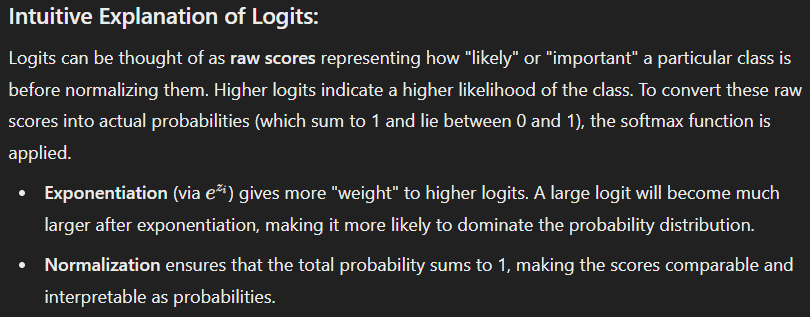

In [19]:
# "Logits" is also a node that is used twice:
# ∂Loss/∂logits = (∂logit_maxes/∂logtis * ∂Loss/∂logit_maxes) + (∂norm_logits/∂logits * ∂Loss/norm_logits)
dlogits = torch.zeros_like(logits).scatter_(1, logits.max(1, keepdim=True).indices, 1) * dlogit_maxes
# We could also achieve the same thing by using F.one_hot or directly scattering "dlogit_maxes".
# "dlogit_maxes" is (32, 1) so it will be broadcasted. In this case, that correctly scatters "dlogit_maxes" where the 1s are.

# ∂norm_logits/∂logits is a tensor of 1s.
dlogits += dnorm_logits

In [20]:
dlogits.shape, h.shape, W2.shape, b2.shape

# (32, 27) = (32, 64) * (64, 27) + (27)     , "dlogits" has the same shape as "logits".

# This means that b2 will be broadcast as follows:

# (32, 64) * (64, 27) = (32, 27)
#                       (    27)    # 1) Pytorch aligns the trailing dimensions.
#                       (1,  27)    # 2) It augments b2's dimensions, turning it into a row vector.
#                       (32, 27)    # 3) The row vector is replicated vertically to form a (32, 27) tensor.

(torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([27]))

##### Use small example to understand the pattern (Very useful strategy in general!):

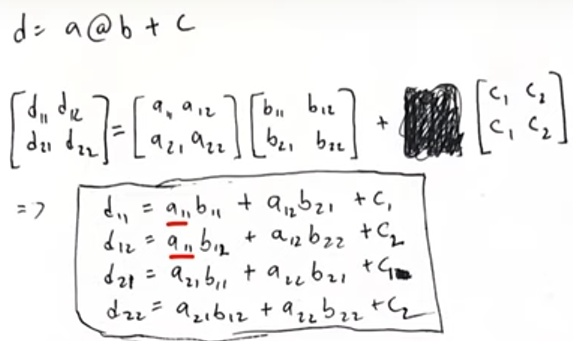

In [21]:
# ∂Loss/∂h = 

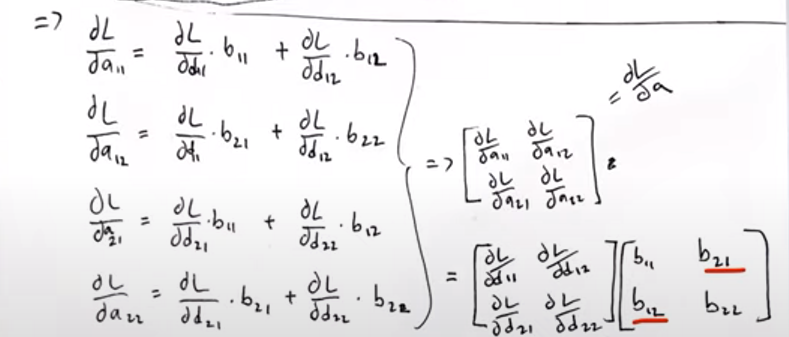

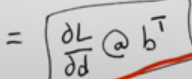

In [22]:
# ∂Loss/∂W =

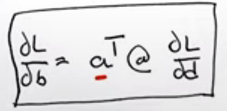

In [23]:
# ∂Loss/∂b =

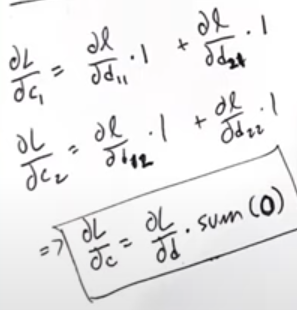

In [24]:
# But there is no need to memorize these formulas or derive them, as we can use the dimensions to guide us:

# Ex:

# 1) The expression for "dh" has to involve the upstream grad, which is ∂Loss/∂logits (which is "dlogits"); and "W2" (the mutliplication partner, since
#    there are no "h" elements involved with "b" elements. Look at the first picture for reference, there h=a and b=c).
# 2) "dh" has to have the same dimensions as "h", which is (32, 64).
# 3) "W2" is (64, 27)
# 4) So "dh = dlogits * W2.T" so the dimensions match.

# The same logic applies to "db2" and "dW2".

In [25]:
dlogits.shape, h.shape, W2.shape, b2.shape

(torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([27]))

In [26]:
# ∂Loss/∂h = ∂Loss/∂logits @ ∂logits/∂h
dh = dlogits @ W2.T

# ∂Loss/∂W2 = ∂Loss/∂logits @ ∂logits/∂W2
dW2 = h.T @ dlogits

# ∂Loss/∂b2 = ∂Loss/∂logits * ∂logits/∂b2
db2 = dlogits.sum(0)      # Sum the contributions due to broadcasting. No need for keepdim because b2.shape = (27).

In [27]:
# ∂Loss/∂hpreact = ∂h/∂hpreact * ∂Loss/∂h

# dhpreact = (1 - torch.tanh(hpreact)**2) * dh

dhpreact = (1 - h**2) * dh # better since h = torch.tanh(hpreact) already.

In [28]:
# ∂Loss/∂bngain = ∂hpreact/∂bngain * ∂Loss/hpreact

dbngain = (bnraw * dhpreact).sum(0, keepdim=True)

In [29]:
# ∂Loss/∂bnbias = ∂hpreact/∂bnbias * ∂Loss/hpreact

# dbnbias = (torch.ones_like(hpreact) * dhpreact).sum(0, keepdim=True)

dbnbias = dhpreact.sum(0, keepdim=True) # more efficient way of writing it.

In [30]:
# ∂Loss/∂bnraw = ∂hpreact/∂bnraw * ∂Loss/hpreact

dbnraw =  bngain * dhpreact

In [31]:
# ∂Loss/∂bnvar_inv = ∂bnraw/∂bnvar_inv * ∂Loss/∂bnraw

dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim = True)

In [32]:
# ∂Loss/∂bnvar = ∂dbnvar_inv/∂bnvar * ∂Loss/∂bnvar_inv

dbnvar = (-0.5 * (bnvar + 1e-5)**-1.5) * dbnvar_inv

In [33]:
# ∂Loss/∂bndiff2 = ∂bnvar/∂bndiff2 * ∂Loss/∂bnvar

dbndiff2 = 1/(n-1) * dbnvar

In [37]:
# ∂Loss/∂bndiff = (∂bnraw/∂bndiff * ∂Loss/∂bnraw) + (∂bndiff2/∂bndiff * ∂Loss/∂bndiff2)

dbndiff = bnvar_inv * dbnraw
dbndiff += 2 * bndiff * dbndiff2

In [44]:
# ∂Loss/∂bnmeani = ∂bndiff/∂bnmeani * ∂Loss/∂bndiff

dbnmeani = (-torch.ones_like(bnmeani) * dbndiff).sum(0, keepdim=True)

In [47]:
# ∂Loss/∂hprebn = (∂bndiff/∂hprebn * ∂Loss/∂bndiff) + (∂bnmeani/∂hprebn * ∂Loss/∂bnmeani)

dhprebn = torch.ones_like(hprebn) * dbndiff
dhprebn += 1/n * dbnmeani

In [51]:
# ∂Loss/∂embcat = ∂Loss/∂hprebn @ ∂hprebn/∂embcat

dembcat = dhprebn @ W1.T

# ∂Loss/∂W1 = ∂Loss/∂hprebn @ ∂hprebn/∂W1

dW1 = embcat.T @ dhprebn

# ∂Loss/∂W1 = ∂Loss/∂hprebn @ ∂hprebn/∂b1

db1 = dhprebn.sum(0, keepdim=True)

In [58]:
# ∂Loss/∂emb = ∂embcat/∂emb * ∂Loss/∂embcat

# demb = torch.ones_like(emb) * dembcat.view(emb.shape[0], emb.shape[1], emb.shape[2])

demb = dembcat.view(emb.shape[0], emb.shape[1], emb.shape[2]) # or more efficiently written.

In [62]:
# ∂Loss/∂C = ∂emb/∂C * ∂Loss/∂emb

# For dC we essentially need to route the upstream gradients from demb into dC depending on which character they belong to, and adding in case of multiple occurences:

dC = torch.zeros_like(C)

for k in range(Xb.shape[0]):        # Go through the whole Xb, which is the tensor of indices of each sample in the minibatch
    for j in range(Xb.shape[1]):
        ix  = Xb[k,j]    # ix is a row index of C, which corresponds to the embeddings for each character. Remember C is (27 chars, 10 embeds).
        dC[ix] += demb[k,j]

In [63]:

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)


logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

## Exercise 2:

In [ ]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

In [ ]:
# backward pass

# -----------------
# YOUR CODE HERE :)
dlogits = None # TODO. my solution is 3 lines
# -----------------

#cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

## Exercise 3:

In [ ]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

In [ ]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
dhprebn = None # TODO. my solution is 1 (long) line
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

## Exercise 4:

In [ ]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
#with torch.no_grad():

# kick off optimization
for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hprebn = embcat @ W1 + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmean = hprebn.mean(0, keepdim=True)
  bnvar = hprebn.var(0, keepdim=True, unbiased=True)
  bnvar_inv = (bnvar + 1e-5)**-0.5
  bnraw = (hprebn - bnmean) * bnvar_inv
  hpreact = bngain * bnraw + bnbias
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward() # use this for correctness comparisons, delete it later!

  # manual backprop! #swole_doge_meme
  # -----------------
  # YOUR CODE HERE :)
  dC, dW1, db1, dW2, db2, dbngain, dbnbias = None, None, None, None, None, None, None
  grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
  # -----------------

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p, grad in zip(parameters, grads):
    p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
    #p.data += -lr * grad # new way of swole doge TODO: enable

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    break